# 模型评价基本流程一览
[大图](模型评价.html), [下载](origin_files/模型评价.ipynb)
## 1. 获取数据，并进行清洗


* 加载数据集

Attribute Information:

1. Sequence Name: Accession number for the SWISS-PROT database 
2. mcg: McGeoch's method for signal sequence recognition. 
3. gvh: von Heijne's method for signal sequence recognition. 
4. lip: von Heijne's Signal Peptidase II consensus sequence score. Binary attribute. 
5. chg: Presence of charge on N-terminus of predicted lipoproteins. Binary attribute. 
6. aac: score of discriminant analysis of the amino acid content of outer membrane and periplasmic proteins. 
7. alm1: score of the ALOM membrane spanning region prediction program. 
8. alm2: score of ALOM program after excluding putative cleavable signal regions from the sequence.

In [1]:
%matplotlib inline
import os
import numpy as np
from scipy import stats
import pandas as pd
import sklearn.model_selection as cross_validation  # Use sklearn.cross_validation in old version
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import sklearn.datasets as datasets
df=pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data',
               header=None,sep='\s+',names=['s_name','mcg','gvh','alm','mit','erl','pox','vac','nuc','target'])
df=df.loc[(df.target=='CYT') |( df.target=='NUC'),'mcg':]
df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
5,0.51,0.40,0.56,0.17,0.5,0.5,0.49,0.22,CYT
7,0.48,0.45,0.59,0.20,0.5,0.0,0.58,0.34,NUC
9,0.40,0.39,0.60,0.15,0.5,0.0,0.58,0.30,CYT
10,0.43,0.39,0.54,0.21,0.5,0.0,0.53,0.27,NUC


## 2. 划分训练集和测试集，并且特征工程

* 划分训练集和测试集

In [3]:
train_data, test_data, train_target, test_target = cross_validation.train_test_split(
    df.iloc[:,:8], df.iloc[:,8], test_size=0.2, train_size=0.8, random_state=123)   #划分训练集和测试集t

* 极值标准化  
这里有个需要注意的点，test应当按照train来进行预处理,而不能用test的信息进行预处理  
这样做是错误的：
   1. 对train做fit_transfrom,对test做fit_transform
   2. 先对所有数据标准化，然后train_test_split

In [4]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(train_data)
train_data_scaled=min_max_scaler.transform(train_data)#fit_transform(train_data)可以两步一起做
test_data_scaled=min_max_scaler.transform(test_data)

## 3. 建模

In [5]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)  # 默认欧氏距离
model.fit(train_data, train_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [6]:
test_predict = model.predict(test_data)
train_predict=model.predict(train_data)

* 混淆矩阵

In [7]:
import sklearn.metrics as metrics
metrics.confusion_matrix(test_target, test_predict, labels=['CYT','NUC'])#label可以控制显示哪些标签

array([[75, 25],
       [39, 40]], dtype=int64)

In [8]:
print(metrics.classification_report(test_target, test_predict))

             precision    recall  f1-score   support

        CYT       0.66      0.75      0.70       100
        NUC       0.62      0.51      0.56        79

avg / total       0.64      0.64      0.64       179



In [9]:
model.score(test_data, test_target)

0.64245810055865926

- ROC

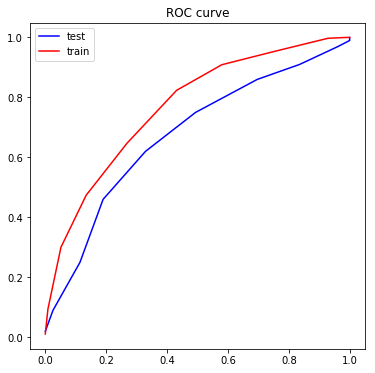

In [10]:
test_proba_predict = model.predict_proba(test_data)[:,0]
train_proba_predict=model.predict_proba(train_data)[:,0]
fpr_test, tpr_test, th_test = metrics.roc_curve(test_target=='CYT', test_proba_predict)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target=='CYT', train_proba_predict)
plt.figure(figsize=[6,6])
plt.plot(fpr_test, tpr_test, color='blue',label='test')
plt.plot(fpr_train, tpr_train, color='red',label='train')
plt.legend()
plt.title('ROC curve')

## Kfold

- [Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html):Split dataset into k consecutive folds (without shuffling by default).
- [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)分层抽样,保证每个集合y值的频率都与整体相等，也是不shuffle
- [GroupKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold)保证同一个group只能出现在同一个集合中
- [LeaveOneGroupOut](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut)GroupKFold的变种，每次只留一个group


[RepeatedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold),[RepeatedStratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold),多了参数n_repeats, random_state，多次重复相应操作，shuffle后抽样，

In [11]:
from sklearn.model_selection import KFold
X = np.arange(2,14,1)
kf = KFold(n_splits=4)

for train_index, test_index in kf.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 3  4  5  6  7  8  9 10 11] TEST: [0 1 2]
TRAIN: [ 0  1  2  6  7  8  9 10 11] TEST: [3 4 5]
TRAIN: [ 0  1  2  3  4  5  9 10 11] TEST: [6 7 8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [ 9 10 11]


In [12]:
from sklearn.model_selection import StratifiedKFold
X = np.arange(2,14,1)
y = np.array([0]*8+[1]*4)
skf = StratifiedKFold(n_splits=3)

for train_index, test_index in skf.split(X, y):
   print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 3  4  5  6  7 10 11] TEST: [0 1 2 8 9]
TRAIN: [ 0  1  2  6  7  8  9 11] TEST: [ 3  4  5 10]
TRAIN: [ 0  1  2  3  4  5  8  9 10] TEST: [ 6  7 11]


In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold
X = np.arange(2,14,1)
y = np.array([0]*6+[1]*6)

rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=1,random_state=36851234)
for train_index, test_index in rskf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 1  3  4  7  9 10] TEST: [ 0  2  5  6  8 11]
TRAIN: [ 0  2  5  6  8 11] TEST: [ 1  3  4  7  9 10]


In [14]:
from sklearn.model_selection import GroupKFold
X = np.arange(2,14,1)
y = np.array([0]*6+[1]*6)
groups = np.array([0]*6+[1]*6)
group_kfold = GroupKFold(n_splits=2)

for train_index, test_index in group_kfold.split(X, y, groups):
    print("TRAIN:", train_index, "TEST:", test_index)



TRAIN: [0 1 2 3 4 5] TEST: [ 6  7  8  9 10 11]
TRAIN: [ 6  7  8  9 10 11] TEST: [0 1 2 3 4 5]


In [15]:
from sklearn.model_selection import LeaveOneGroupOut
X = np.arange(2,14,1)
y = np.array([0]*6+[1]*6)
logo = LeaveOneGroupOut()

logo.get_n_splits(groups=groups) # 'groups' is always required

for train_index, test_index in logo.split(X, y, groups):
   print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 6  7  8  9 10 11] TEST: [0 1 2 3 4 5]
TRAIN: [0 1 2 3 4 5] TEST: [ 6  7  8  9 10 11]


## GridSearchCV

In [16]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold

n_samples = len(train_data)
grid = ParameterGrid({'n_neighbors':[range(4,10)]})
estimator = KNeighborsClassifier()

kf = KFold(n_splits=3)

gridSearchCV = GridSearchCV(estimator, grid, cv=kf)#RepeatedKFold,StratifiedKFold等等

gridSearchCV.fit(train_data, train_target.values.flatten())


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=<sklearn.model_selection._search.ParameterGrid object at 0x000001671614FB00>,
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

下面是一个神经网络的例子，多参数

In [17]:
# param_grid = {
#     'hidden_layer_sizes':[(10, ), (15, ), (20, ), (5, 5)],
#     'activation':['logistic', 'tanh', 'relu'], 
#     'alpha':[0.001, 0.01, 0.1, 0.2, 0.4, 1, 10]
# }
# mlp = MLPClassifier(max_iter=1000)
# gcv = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)

In [18]:
gridSearchCV.cv_results_

{'mean_fit_time': array([ 0.00217239,  0.00162236,  0.00067139,  0.00101693,  0.00130669,
         0.00033418]),
 'mean_score_time': array([ 0.00517066,  0.00246819,  0.00166758,  0.002045  ,  0.00238601,
         0.00066821]),
 'mean_test_score': array([ 0.59607293,  0.60729313,  0.61290323,  0.6171108 ,  0.61430575,
         0.62131837]),
 'mean_train_score': array([ 0.73844906,  0.74054696,  0.71669615,  0.72231166,  0.7054843 ,
         0.71179714]),
 'param_n_neighbors': masked_array(data = [4 5 6 7 8 9],
              mask = [False False False False False False],
        fill_value = ?),
 'params': [{'n_neighbors': 4},
  {'n_neighbors': 5},
  {'n_neighbors': 6},
  {'n_neighbors': 7},
  {'n_neighbors': 8},
  {'n_neighbors': 9}],
 'rank_test_score': array([6, 5, 4, 2, 3, 1]),
 'split0_test_score': array([ 0.56302521,  0.60504202,  0.60504202,  0.60084034,  0.60504202,
         0.60084034]),
 'split0_train_score': array([ 0.75368421,  0.75789474,  0.72631579,  0.74526316,  0.7178947

In [19]:
gridSearchCV.best_score_
gridSearchCV.best_params_
best = gridSearchCV.best_estimator_ 
best.score(test_data, test_target)

0.66480446927374304